<a href="https://colab.research.google.com/github/vasist1987/hackathon_notebooks/blob/master/predictTaxiDemandJBTHON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing necessary libraries


In [1]:
import pandas as pd
!pip install prophet
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
!pip install optuna
import optuna
!pip install pandasql
from pandasql import sqldf
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE
from warnings import simplefilter
from math import sqrt


In [2]:
train=pd.read_csv("/content/train_E1GspfA.csv")
test=pd.read_csv("/content/test_6QvDdzb.csv")
sample_submission=pd.read_csv("/content/sample_4E0BhPN.csv")

In [3]:
# train['date_new'] = pd.to_datetime(train.date)
train['date_new']=pd.to_datetime(train.date+" "+train.hour.astype(str).str.pad(2, side='left', fillchar='0')+":00:00")
test['date_new']=pd.to_datetime(test.date+" "+test.hour.astype(str).str.pad(2, side='left', fillchar='0')+":00:00")

In [4]:
# df=train.drop(['date','hour'],axis=1)[['date_new','demand']]
# df.columns=['ds','y']
# df.head()

In [5]:
# m = Prophet(interval_width = 0.95,mcmc_samples=30)
# m.fit(df)

In [6]:
# future = m.make_future_dataframe(periods=365)
# future.tail()

In [7]:
# y_pred=m.predict(pd.DataFrame(df.ds))
# sqrt(MSE(df.y, y_pred['yhat']))


In [8]:
# yy=m.predict(pd.DataFrame(df.ds))


In [9]:
# pd.concat([yy.yhat,df],axis=1).tail(20)

In [10]:
train['date_new'] = pd.to_datetime(train.date)
train['dayOfWeek']=train.date_new.dt.dayofweek
test['date_new'] = pd.to_datetime(test.date)
test['dayOfWeek']=test.date_new.dt.dayofweek

In [11]:
train.head()

,date,hour,demand,date_new,dayOfWeek
0,2018-08-18,9,91,2018-08-18,5
1,2018-08-18,10,21,2018-08-18,5
2,2018-08-18,13,23,2018-08-18,5
3,2018-08-18,14,104,2018-08-18,5
4,2018-08-18,15,81,2018-08-18,5


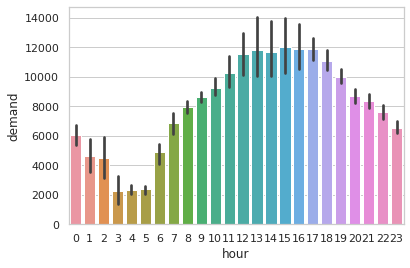

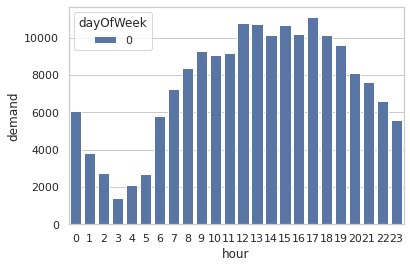

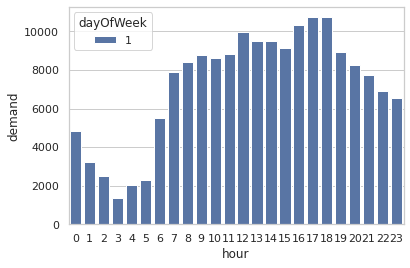

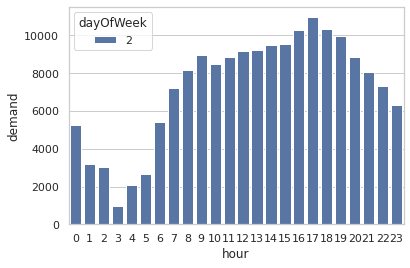

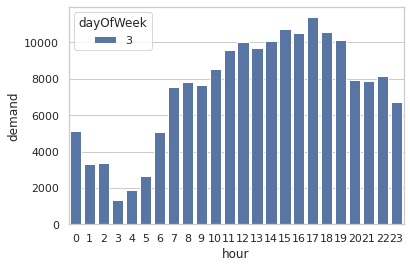

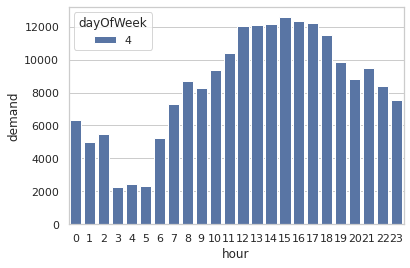

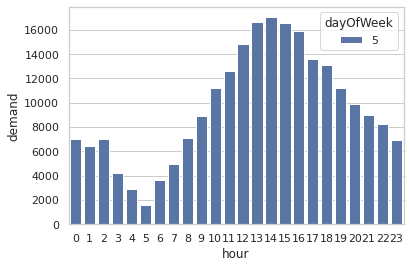

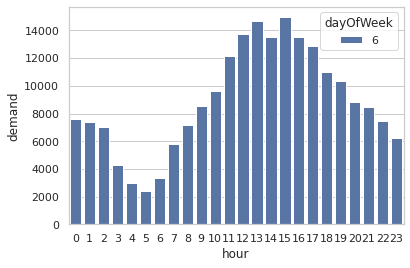

In [12]:
df=pd.DataFrame(train[['dayOfWeek','demand','hour']].groupby(['hour','dayOfWeek']).sum()).reset_index()
sns.set_theme(style="whitegrid")
plt.figure()
sns.barplot(x="hour", y="demand",  data=df)
for i in range(7):
  plt.figure()
  sns.barplot(x="hour", y="demand",hue="dayOfWeek",  data=df[df.dayOfWeek==i])

In [13]:
# train['prev_week']=train.groupby(['hour','date'])['demand'].mean()

In [14]:
# train[(train.hour==12) & (train.dayOfWeek==2)].head()

In [15]:
train['year'] = pd.DatetimeIndex(train['date_new']).year
train['month'] = pd.DatetimeIndex(train['date_new']).month
train['quarter'] = pd.DatetimeIndex(train['date_new']).quarter

test['year'] = pd.DatetimeIndex(test['date_new']).year
test['month'] = pd.DatetimeIndex(test['date_new']).month
test['quarter'] = pd.DatetimeIndex(test['date_new']).quarter

# train.drop(['date','date_new'],axis=1,inplace=True)
train.head()


,date,hour,demand,date_new,dayOfWeek,year,month,quarter
0,2018-08-18,9,91,2018-08-18,5,2018,8,3
1,2018-08-18,10,21,2018-08-18,5,2018,8,3
2,2018-08-18,13,23,2018-08-18,5,2018,8,3
3,2018-08-18,14,104,2018-08-18,5,2018,8,3
4,2018-08-18,15,81,2018-08-18,5,2018,8,3


In [16]:
train['demand_log']=np.log10(train['demand'])
train.loc[train['date_new'].dt.date > datetime.date(2020,1,1), 'Covid'] = 1
train.loc[train['date_new'].dt.date <= datetime.date(2022,4,1), 'Covid'] = 0
# test['demand_log']=np.log(test['demand'])
test.loc[test['date_new'].dt.date > datetime.date(2020,1,1), 'Covid'] = 1
test.loc[test['date_new'].dt.date <= datetime.date(2022,4,1), 'Covid'] = 0

In [17]:
train['demand_log'].describe()
# train['demand_inverse']=10**np.log10(train["demand"])
# train

count    18247.000000
mean         1.784439
std          0.307278
min          0.000000
25%          1.633468
50%          1.851258
75%          1.991226
max          2.578639
Name: demand_log, dtype: float64

year
2018    AxesSubplot(0.125,0.125;0.775x0.755)
2019    AxesSubplot(0.125,0.125;0.775x0.755)
2020    AxesSubplot(0.125,0.125;0.775x0.755)
2021    AxesSubplot(0.125,0.125;0.775x0.755)
Name: demand_log, dtype: object

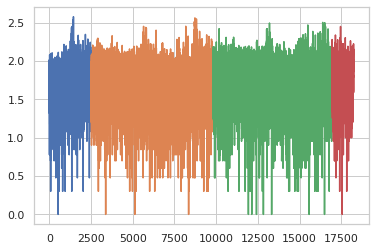

In [18]:
train.groupby(['year'])['demand_log'].plot(x='year',y='demand_log')

In [73]:

train['detrended'] = signal.detrend(train['demand_log'].values)
train['train']=1
test['train']=0
df_test=pd.concat([train,test])
tt=sqldf("select date,hour,year,demand_log demand,month,quarter,dayOfWeek,Covid,coalesce((select avg(demand_log) from train B where B.hour=A.hour and B.dayOfWeek=A.dayOfWeek  and B.year<A.year),0) as detrended_old " \
         +",coalesce((select avg(demand_log) from train B where B.hour=A.hour and B.dayOfWeek=A.dayOfWeek),demand_log) as detrended_oldweeks," \
         +"coalesce((select avg(demand_log) from train B where B.hour=A.hour),demand_log) as detrended_sameHour from df_test A where train=0")
tt
df=sqldf("select hour,year,demand_log demand,month,quarter,dayOfWeek,Covid,coalesce((select avg(demand_log) from train B where B.hour=A.hour and B.dayOfWeek=A.dayOfWeek and B.year<A.year),detrended) as detrended_old" \
         +",coalesce((select avg(demand_log) from train B where B.hour=A.hour and B.dayOfWeek=A.dayOfWeek),demand_log) as detrended_oldweeks," \
         +"coalesce((select avg(demand_log) from train B where B.hour=A.hour),demand_log) as detrended_sameHour from train A")
df[(df.year==2020)]

,hour,year,demand,month,quarter,dayOfWeek,Covid,detrended_old,detrended_oldweeks,detrended_sameHour
9797,0,2020,1.662758,1,1,2,0.0,1.647784,1.659579,1.669468
9798,1,2020,1.612784,1,1,2,0.0,1.643550,1.586884,1.639862
9799,3,2020,1.505150,1,1,2,0.0,1.588430,1.678256,1.641492
9800,5,2020,1.982271,1,1,2,0.0,1.617080,1.620319,1.556947
9801,6,2020,1.954243,1,1,2,0.0,1.561328,1.561976,1.582584
...,...,...,...,...,...,...,...,...,...,...
16937,19,2020,2.103804,12,4,3,0.0,1.831241,1.844315,1.831435
16938,20,2020,1.623249,12,4,3,0.0,1.678139,1.717967,1.776227
16939,21,2020,2.017033,12,4,3,0.0,1.737046,1.730252,1.756679
16940,22,2020,1.380211,12,4,3,0.0,1.798510,1.750544,1.712261


In [74]:
tt

,date,hour,year,demand,month,quarter,dayOfWeek,Covid,detrended_old,detrended_oldweeks,detrended_sameHour
0,2021-03-01,0,2021,None,3,1,0,0.0,1.701027,1.708483,1.669468
1,2021-03-01,1,2021,None,3,1,0,0.0,1.652190,1.640098,1.639862
2,2021-03-01,2,2021,None,3,1,0,0.0,1.594892,1.601220,1.655107
3,2021-03-01,3,2021,None,3,1,0,0.0,1.597888,1.605737,1.641492
4,2021-03-01,5,2021,None,3,1,0,0.0,1.535253,1.526744,1.556947
...,...,...,...,...,...,...,...,...,...,...,...
7645,2022-03-28,19,2022,None,3,1,0,0.0,1.819938,1.819938,1.831435
7646,2022-03-28,20,2022,None,3,1,0,0.0,1.760531,1.760531,1.776227
7647,2022-03-28,21,2022,None,3,1,0,0.0,1.726767,1.726767,1.756679
7648,2022-03-28,22,2022,None,3,1,0,0.0,1.640789,1.640789,1.712261


In [80]:
#'hour','dayOfWeek','detrended_old','detrended_oldweeks','detrended_sameHour'
scaler = MinMaxScaler()
X=train.dropna()
X_train = scaler.fit_transform(df[['hour','dayOfWeek']])
X_test = scaler.transform(tt[['hour','dayOfWeek']])
y=df.demand
# y_test=tt.demand
# X_test = scaler.transform(X_test)
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y, test_size=0.05)
dtrain = lgb.Dataset(train_x, label=train_y)
dvalid = lgb.Dataset(valid_x, label=valid_y)

In [95]:

# from sklearn.multioutput import MultiOutputRegressor
class Objective():

    def __init__(self):
        self.best_booster = None
        self._booster = None

    def __call__(self, trial):
        param = {
            "objective": "regression",
            "metric": "mse",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "bagging_fraction": trial.suggest_loguniform("bagging_fraction", 0.9, 1.0),
            "feature_fraction": trial.suggest_loguniform("feature_fraction", 0.8, 1.0),
            "min_gain_to_split": trial.suggest_loguniform("min_gain_to_split", 0.3, 1.0),
            "max_depth": trial.suggest_int("max_depth", 5, 20),
            "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
            "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
            "num_leaves": trial.suggest_int("num_leaves", 10, 50),
            "num_iterations": trial.suggest_int("num_iterations", 20, 400),
            "learning_rate":trial.suggest_loguniform("learning_rate", 0.01, 0.1),
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
            "max_bin":trial.suggest_int("max_bin", 500, 2000),
             "categorical_feature": "auto"
        }
        # Add a callback for pruning.
        # train_data = lgb.Dataset(X_train_minmax, label=y, free_raw_data=False)
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "mse")
        model= lgb.LGBMRegressor()
        gbm = model.fit(train_x,train_y)

        self._booster = gbm

        preds = gbm.predict(train_x)
        pred_labels = np.rint(preds)
        accuracy = mean_absolute_error(train_y, pred_labels)
        return accuracy


In [96]:
objective = Objective()

simplefilter("ignore", category=RuntimeWarning)
optuna.logging.set_verbosity(optuna.logging.ERROR)
study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize"
)
study.optimize(objective, n_trials=50)

print("Best trial:")
trial_co = study.best_trial

print("  Params: ")
for key, value in trial_co.params.items():
    print("    {}: {}".format(key, value))

best_model_co = objective.best_booster

Best trial:
  Params: 
    bagging_fraction: 0.9032958834878667
    feature_fraction: 0.8163430134708293
    min_gain_to_split: 0.4191245556815868
    max_depth: 20
    lambda_l1: 0.9917078940937806
    lambda_l2: 0.004914875988712837
    num_leaves: 50
    num_iterations: 118
    learning_rate: 0.04151908496504281
    n_estimators: 891
    max_bin: 1991


In [97]:
params =  trial_co.params
model= lgb.LGBMRegressor(**params)
model_co = model.fit(train_x,train_y)
pd.DataFrame({'Value':model.feature_importances_,'Feature':['hour','dayOfWeek']})


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


,Value,Feature
0,322,hour
1,87,dayOfWeek


In [98]:
y_pred=model_co.predict(train_x)
sqrt(MSE(train_y, y_pred))

0.28647619856128137

In [99]:
# model_co = model.fit(valid_x,valid_y)
y_pred=model_co.predict(valid_x)
sqrt(MSE(valid_y, y_pred))

0.2777590232979907

In [86]:
# model_co = model.fit(X_test,y_test)
y_pred=10**model_co.predict(X_test)
# sqrt(MSE(y_test, y_pred))

In [87]:
pd.DataFrame(y_pred)

,0
0,42.347830
1,42.347830
2,42.347830
3,41.124581
4,38.371548
...,...
7645,63.095932
7646,56.655323
7647,54.135100
7648,49.426293


In [88]:
submission=pd.concat([test[['date','hour']],pd.DataFrame(y_pred)],axis=1)
submission.columns=['date','hour','demand']
submission.to_csv("/content/submission.csv", index = False)

In [89]:
from  sklearn.ensemble import RandomForestRegressor
md=RandomForestRegressor(max_depth=50,n_estimators=25)
md.fit(train_x,train_y)
y_r=md.predict(train_x)
sqrt(MSE(train_y, y_r))

0.2830859244302397

In [90]:

y_r=md.predict(valid_x)
sqrt(MSE(valid_y, y_r))

0.2764565956478131

In [91]:
y_pred=md.predict(X_test)
submission=pd.concat([test[['date','hour']],pd.DataFrame(y_pred)],axis=1)
submission.columns=['date','hour','demand']
submission.to_csv("/content/submission_RF.csv", index = False)

In [92]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_x,train_y)
y_r=reg.predict(train_x)
sqrt(MSE(train_y, y_r))
# y_r

0.30164668140663475

In [93]:
y_r=reg.predict(valid_x)
sqrt(MSE(valid_y, y_r))

0.2932011382422708

In [94]:
y_pred=reg.predict(X_test)
submission=pd.concat([test[['date','hour']],pd.DataFrame(y_pred)],axis=1)
submission.columns=['date','hour','demand']
submission.to_csv("/content/submission_reg.csv", index = False)

In [115]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM,RepeatVector
from keras.layers import Dense

In [ ]:
# train_x.shape[1]
# X = train_x.reshape((train_x.shape[0], train_x.shape[1], 6))
model = Sequential()
model.add(Dense(1024))
model.add(RepeatVector(3))
model.add(LSTM(256, activation='relu',return_sequences=True))
model.add(LSTM(256, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(train_x, train_y, epochs=200)

Epoch 1/200
485/485 [==============================] - 36s 68ms/step - loss: 1360.5632
Epoch 2/200
485/485 [==============================] - 33s 68ms/step - loss: 1125.3099
Epoch 3/200
485/485 [==============================] - 33s 68ms/step - loss: 1084.6011
Epoch 4/200
485/485 [==============================] - 34s 69ms/step - loss: 1064.2393
Epoch 5/200
485/485 [==============================] - 34s 70ms/step - loss: 1066.8562
Epoch 6/200
485/485 [==============================] - 33s 69ms/step - loss: 1040.6423
Epoch 7/200
485/485 [==============================] - 33s 68ms/step - loss: 1024.6382
Epoch 8/200
485/485 [==============================] - 33s 68ms/step - loss: 1032.4869
Epoch 9/200
485/485 [==============================] - 33s 69ms/step - loss: 1008.6002
Epoch 10/200
485/485 [==============================] - 33s 68ms/step - loss: 1036.2838
Epoch 11/200
485/485 [==============================] - 34s 69ms/step - loss: 1010.0948
Epoch 12/200
485/485 [===================